# カテゴリ分布の学習と予測

### カテゴリ分布の学習と予測：実装のための要点

これは、コインの表裏（2択）を扱ったベルヌーイ分布の一般化であり、サイコロの目（6択）のような K個の選択肢がある事象をモデル化します。

#### 1\. モデルの構成要素

  * **尤度関数 (Likelihood): カテゴリ分布**

      * **目的**: 1回の試行で K個の選択肢のうち、どの結果 `s` が観測されるかを表します。
      * **数式**: $$p(\mathbf{s}|\mathbf{\pi}) = \text{Cat}(\mathbf{s}|\mathbf{\pi}) = \prod_{k=1}^{K} \pi_k^{s_k}$$
      * **解説**:
          * `π` (パイ) は K次元の確率ベクトルで、`π_k` は k番目の選択肢が選ばれる確率です (`Σπ_k = 1`)。これが推定したい**パラメータ**です。
          * `s` は観測データで、one-hotベクトル（例: 3番目が観測されたら `s = (0, 0, 1, 0, 0, 0)`）で表現されます。

  * **事前分布 (Prior): ディリクレ分布**

      * **目的**: パラメータベクトル `π` に対する事前の信念を表します。
      * **数式**: $$p(\mathbf{\pi}) = \text{Dir}(\mathbf{\pi}|\mathbf{\alpha})$$
      * **解説**:
          * ディリクレ分布は、カテゴリ分布の**共役事前分布**です。これにより事後分布もディリクレ分布となり、計算が簡単になります。
          * `α` (アルファ) は K次元のベクトルで、**ハイパーパラメータ**と呼ばれます。各要素 `α_k` は、k番目の選択肢の「仮想的な観測カウント」と解釈できます。

#### 2\. 学習 (Learning): 事後分布の導出

観測データ `S = {s_1, ..., s_N}` を得た後、事後分布 `p(π|S)` を計算します。

  * **結果**: 事後分布もディリクレ分布になります。
      * **数式**: $$p(\mathbf{\pi}|S) = \text{Dir}(\mathbf{\pi}|\hat{\mathbf{\alpha}})$$
  * **パラメータの更新式**:
      * $$\hat{\alpha}_k = \alpha_k + \sum_{n=1}^{N} s_{n,k} = \alpha_k + (\text{k番目の選択肢が観測された回数 } N_k)$$
      * **解説**: 更新後のハイパーパラメータ `α̂_k` は、元の `α_k` に、データ中で k番目の選択肢が観測された回数を足すだけで計算できます。

#### 3\. 予測 (Prediction): 予測分布の導出

学習済みの事後分布を使い、次に観測されるデータ `s*` の確率（予測分布）を計算します。

  * **結果**: 予測分布はカテゴリ分布になります。
      * **数式**: $$p(\mathbf{s}_*|S) = \text{Cat}(\mathbf{s}_* | \frac{\hat{\mathbf{\alpha}}}{\sum_{k=1}^{K}\hat{\alpha}_k})$$
  * **予測確率**: 次に k番目の選択肢が観測される確率は、事後分布の期待値で与えられます。
      * $$P(s_{*k}=1|S) = \frac{\hat{\alpha}_k}{\sum_{j=1}^{K}\hat{\alpha}_j} = \frac{\alpha_k + N_k}{\sum_{j=1}^{K}(\alpha_j + N_j)}$$

-----

### シナリオとPythonサンプルコード

**シナリオ**:
とあるイカサマ師が持つ、少し**歪んだ6面のサイコロ**があります。このサイコロの各目が出る確率を、実際に何度も振って学習していく過程をシミュレーションします。

  * **真の確率**: サイコロの各目が出る真の確率は `[0.1, 0.1, 0.1, 0.2, 0.2, 0.3]` とします（6の目が出やすい）。この値は我々には未知です。
  * **事前分布**: 特に情報がないため、各目が出る確率は均等だろうという立場で、`α = (1, 1, 1, 1, 1, 1)` という無情報な事前分布を設定します。


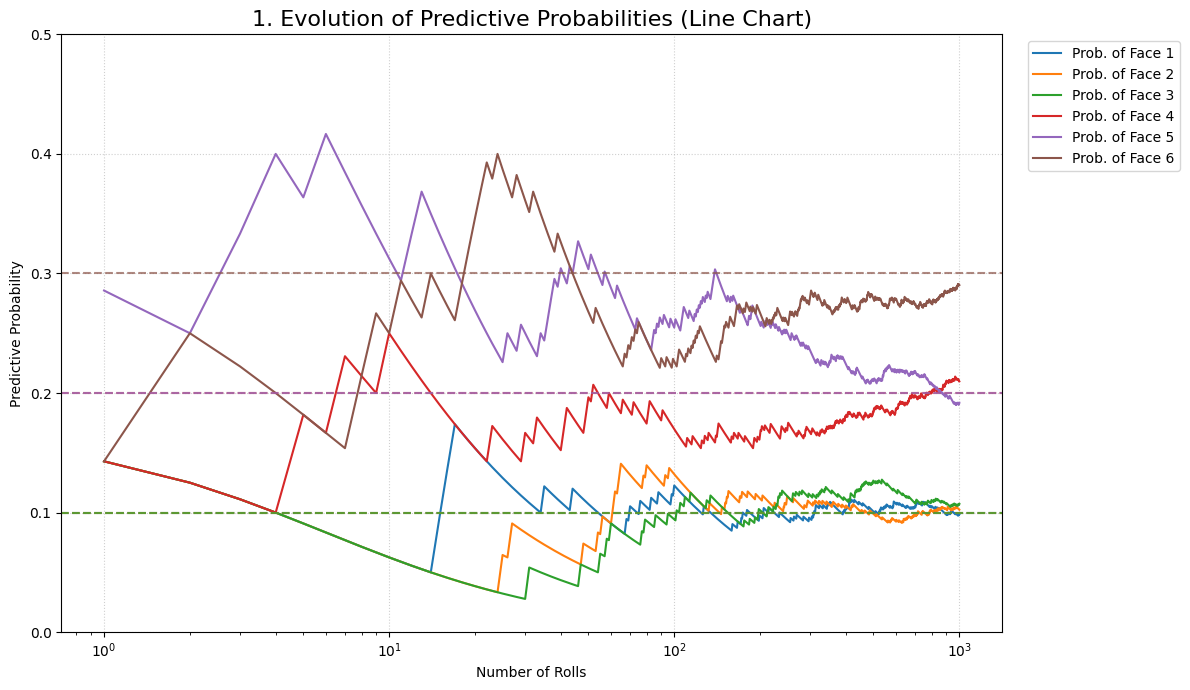

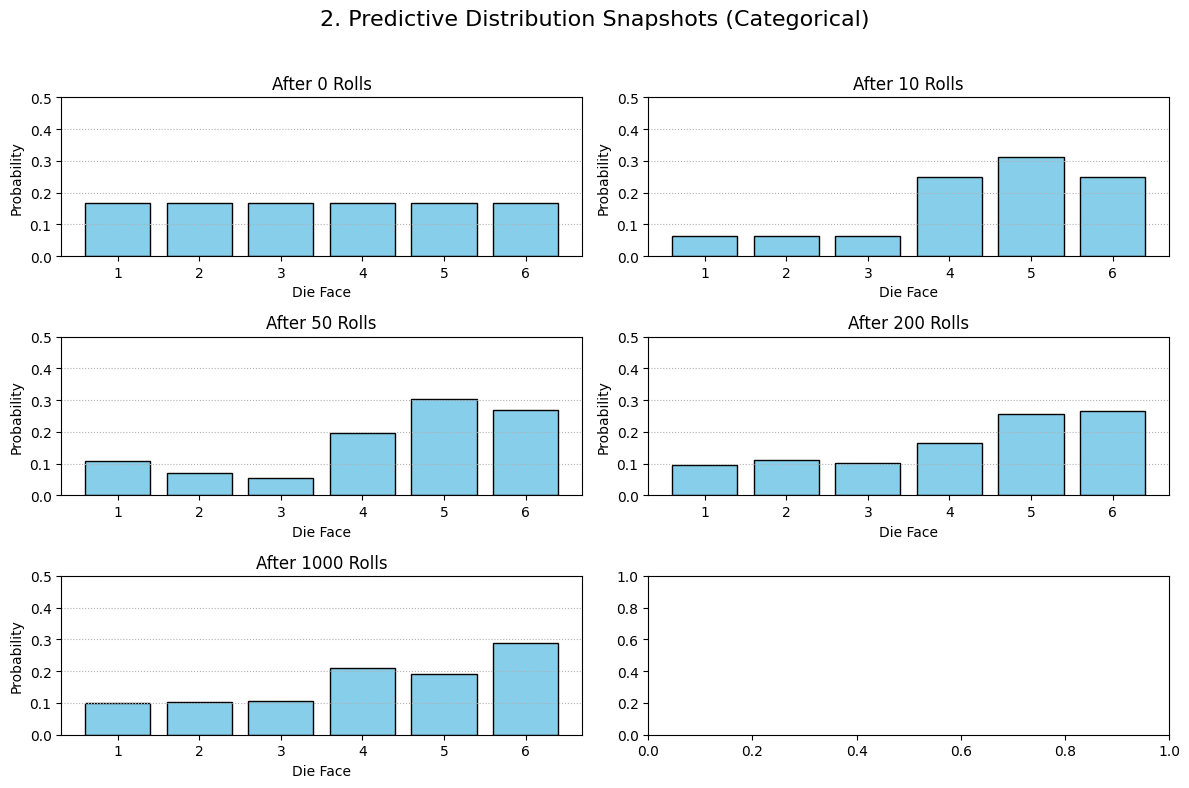

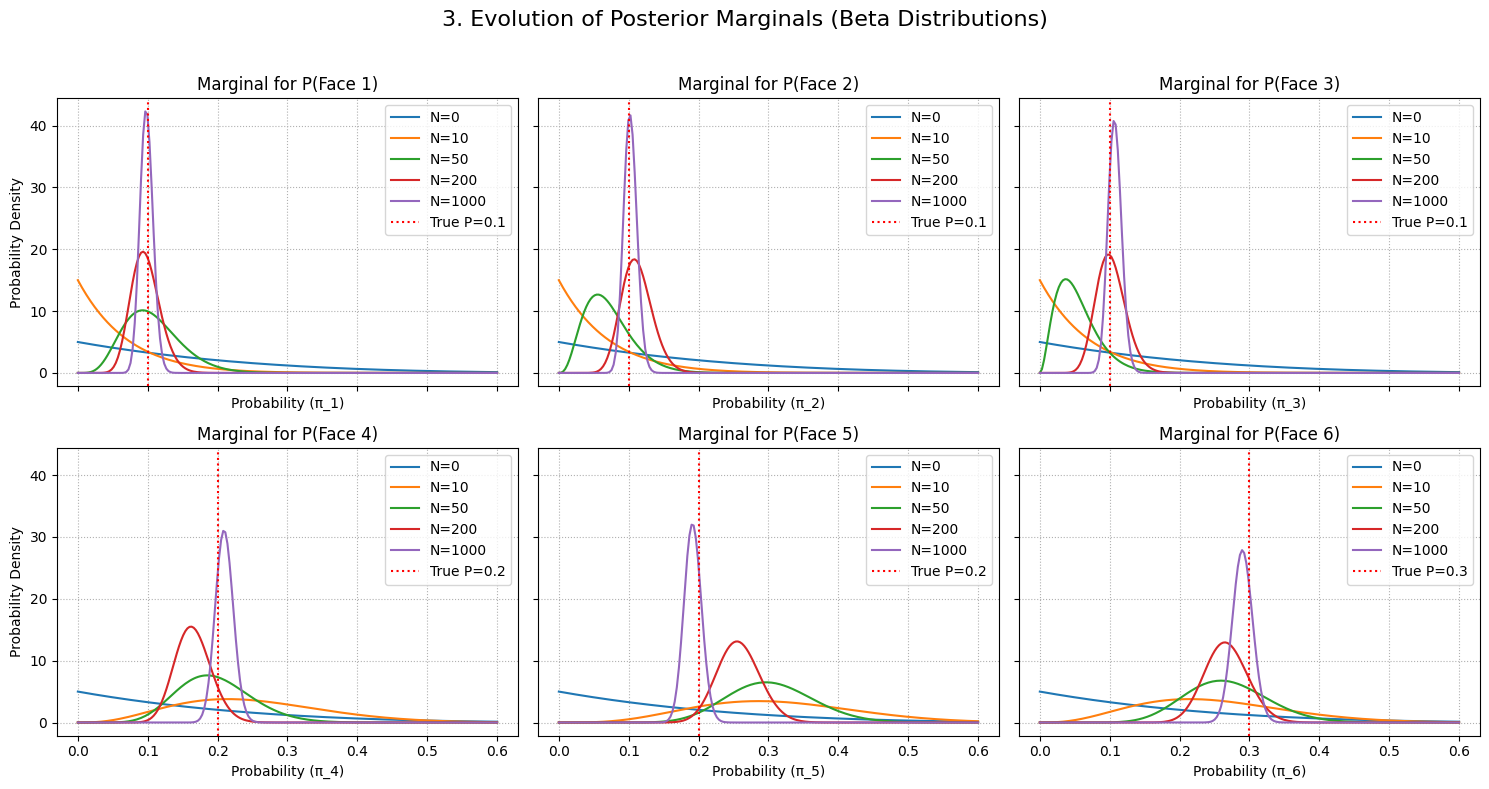

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import math

# --- 1. シナリオ設定 ---
K = 6
pi_true = np.array([0.1, 0.1, 0.1, 0.2, 0.2, 0.3])
alpha_prior = np.ones(K)
num_trials = 1000
np.random.seed(0)  # 毎回同じ結果にするためのシード固定
data = np.random.choice(K, size=num_trials, p=pi_true)

# --- 2. 学習過程のデータをすべて記録 ---

# 折れ線グラフ用の履歴
predictive_history = []
# スナップショット用のデータ
plot_points = [0, 10, 50, 200, 1000]
snapshot_results = {}

for i in range(num_trials + 1):
    if i == 0:
        counts = np.zeros(K)
    else:
        current_data = data[:i]
        counts = np.bincount(current_data, minlength=K)

    alpha_hat = alpha_prior + counts
    pred_probs = alpha_hat / np.sum(alpha_hat)

    # 折れ線グラフ用に毎回の予測を記録 (i=0は事前分布なのでi>0で記録)
    if i > 0:
        predictive_history.append(pred_probs)

    # スナップショット用に特定の時点のデータを記録
    if i in plot_points:
        snapshot_results[i] = {"alpha_hat": alpha_hat, "pred_probs": pred_probs}

predictive_history = np.array(predictive_history)


# --- 3. 可視化 ---

## グラフ1: 予測確率の推移（折れ線グラフ）
plt.figure(figsize=(12, 7))
for k in range(K):
    plt.plot(
        range(1, num_trials + 1),
        predictive_history[:, k],
        label=f"Prob. of Face {k + 1}",
    )
for k in range(K):
    plt.axhline(y=pi_true[k], color=f"C{k}", linestyle="--", alpha=0.7)
plt.title("1. Evolution of Predictive Probabilities (Line Chart)", fontsize=16)
plt.xlabel("Number of Rolls")
plt.xscale("log")
plt.ylabel("Predictive Probability")
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.ylim(0, 0.5)
plt.tight_layout()
plt.show()


## グラフ2: 予測分布の変遷（棒グラフ）
fig2, axes2 = plt.subplots(math.ceil(len(plot_points) / 2), 2, figsize=(12, 8))
fig2.suptitle("2. Predictive Distribution Snapshots (Categorical)", fontsize=16)
axes2 = axes2.flatten()
for i, n in enumerate(plot_points):
    ax = axes2[i]
    probs = snapshot_results[n]["pred_probs"]
    ax.bar(range(1, K + 1), probs, color="skyblue", edgecolor="black")
    ax.set_title(f"After {n} Rolls")
    ax.set_xlabel("Die Face")
    ax.set_ylabel("Probability")
    ax.set_ylim(0, 0.5)
    ax.grid(axis="y", linestyle=":")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## グラフ3: 事後分布（周辺分布）の変遷（曲線グラフ）
# その目か、それ以外かでベータ分布を6つ描画
fig3, axes3 = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)
fig3.suptitle("3. Evolution of Posterior Marginals (Beta Distributions)", fontsize=16)
axes3 = axes3.flatten()
x = np.linspace(0, 0.6, 200)  # x軸の範囲を調整
for k in range(K):
    ax = axes3[k]
    ax.set_title(f"Marginal for P(Face {k + 1})")
    for n in plot_points:
        alpha_hat = snapshot_results[n]["alpha_hat"]
        a = alpha_hat[k]
        b = np.sum(alpha_hat) - a
        ax.plot(x, beta.pdf(x, a, b), label=f"N={n}")
    ax.axvline(x=pi_true[k], color="r", linestyle=":", label=f"True P={pi_true[k]:.1f}")
    ax.set_xlabel(f"Probability (π_{k + 1})")
    ax.grid(True, linestyle=":")
    ax.legend()
axes3[0].set_ylabel("Probability Density")
axes3[3].set_ylabel("Probability Density")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
